In [1]:
##### >>>>> RUN THIS CELL #1 <<<<< #####
##### Library definition

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container {width:95% !important;</style>")) # make jupyter use a decent width of the screen

%matplotlib notebook

# Import standard libraries 
import math
from time import time, sleep
from functools import partial
from pathlib import Path
# Import scipy/numpy
import numpy as np
from scipy.ndimage.measurements import center_of_mass
from scipy.special import erf
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
import os

# Import NSLS libraries
from ophyd import EpicsSignalRO, EpicsSignal
from bluesky.plans import rel_scan, count
from bluesky import RunEngine
# new two lines NK added
from bluesky.plans import list_scan
import bluesky.preprocessors as bpp
import bluesky.plan_stubs as bps
####### 28/07/2021
from saxs_beamline_library.plans.saxs_plans import gappy_plan, gapless_plan
from saxs_beamline_library.plans.default_detectors import get_detectors
import saxs_beamline_library.plans.saxs_plan_stubs as sps
import saxs_beamline_library.plans.gapless_plan_stubs as gps
#######

from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky.callbacks import LiveFit, LiveFitPlot, LivePlot, LiveTable
from bluesky.callbacks.core import CallbackBase
from bluesky.utils import install_kicker

# Import saxs_beamline_library stuffs
from saxs_beamline_library.acquisition.saxs_acquire_engine import SAXSAcquire

from saxs_beamline_library.devices.saxs_detectors import saxs_detector

#from saxs_beamline_library.devices.saxs_detectors import saxs_detector, gapless_saxs_detector
from saxs_beamline_library.devices.saxs_shutter import EpicsSAXSShutter
from saxs_beamline_library.devices.saxs_feedback import fb
from saxs_beamline_library.devices.saxs_redis import saxs_redis_signal_factory
from saxs_beamline_library.devices.saxs_motors import in_vac, saxs_det, beamstop, gsaxs, mc7 #,mc8
from saxs_beamline_library.acquisition.saxs_gapless import GaplessMode, Position
from saxs_beamline_library.devices.saxs_slits import slit_1
from saxs_beamline_library.devices.saxs_attenuators import saxs_attenuators
from saxs_beamline_library.devices.saxs_redis_signal_conf import (gsaxs_acquire_det_pos_x, 
                                                                 gsaxs_acquire_det_pos_y, 
                                                                 gsaxs_slit_centre_y, 
                                                                 stored_beam_counts, 
                                                                 stored_gapless_mode,
                                                                 gapless_x_centre,
                                                                 gapless_y_centre)

from saxs_beamline_library.acquisition.energy_change import EnergyChange
from saxs_beamline_library.devices.saxs_mcc import usbtemp1

from epics import PV

# Make plots update live while scans run.
install_kicker()

# feedback camera
fdbk_shutter_time = PV('SR13ID01VC1:cam1:AcquireTime')

mono_shutter_open = PV('SR13ID01PSS01:MONO_SHUTTER_OPEN_CMD')
mono_shutter_close = PV('SR13ID01PSS01:MONO_SHUTTER_CLOSE_CMD')
mono_shutter_closed_sts = PV('SR13ID01PSS01:MONO_SHUTTER_CLOSED_STS')
hutch2_searched_sts = PV('SR13ID01PSS01:HU02_SEARCHED_STS')

# Detector
gapless_mode = GaplessMode('SR13ID01PYSEQ01:', name='Gapless_mode')
file_template = EpicsSignal('SR13ID01PIL1:cam1:FileTemplate_RBV', write_pv='SR13ID01PIL1:cam1:FileTemplate', name='file_template')

# Shutters
exp_shutter = EpicsSAXSShutter('SR13ID01HU02IOC02:', name='Experimental_shutter')

# Stats
counts = EpicsSignalRO('SR13ID01PIL1:ROIStat1:1:Total_RBV', name='counts')
roi_x = EpicsSignal('SR13ID01PIL1:ROIStat1:1:MinX', name='roi_min_x')
roi_width = EpicsSignal('SR13ID01PIL1:ROIStat1:1:SizeX', name='roi_width')
roi_y = EpicsSignal('SR13ID01PIL1:ROIStat1:1:MinY', name='roi_min_y')
roi_height = EpicsSignal('SR13ID01PIL1:ROIStat1:1:SizeY', name='roi_height')
stats_1_enable = EpicsSignal('SR13ID01PIL1:ROIStat1:EnableCallbacks', name='roi_stats_enable')
stats_1_1_enable = EpicsSignal('SR13ID01PIL1:ROIStat1:1:Use', name='roi_stats_1_enable')

pitch_offset = EpicsSignal('SR13ID01:GSAX_OMG.OFF', name='pitch_user_offset') # is for gsaxsrig

# Callbacks
bec = BestEffortCallback()
RE = RunEngine({})
RE.subscribe(bec)

config_path = "/config/saxs_config.yaml"
sa = SAXSAcquire(config_path)
detectors = get_detectors(config_path)

saxs_det_x_pv = PV('SR13ID01:SAX_DET_X.VAL')
saxs_det_y_pv = PV('SR13ID01:SAX_DET_Y.VAL')
beamstop_x_pv = PV('SR13ID01HU02IOC02:BST_X_MTR.VAL')
beamstop_y_pv = PV('SR13ID01HU02IOC02:BST_Y_MTR.VAL')

# controls for manual alignment
saxs_det_trigger_mode = PV('SR13ID01PIL1:cam1:TriggerMode')
saxs_det_acquire = PV('SR13ID01PIL1:cam1:Acquire')
manual_shutter_open = PV('SR13ID01:MANUAL_SHUTTER_OPEN.PROC')
manual_shutter_close = PV('SR13ID01:FDBK_DET_REQ.VAL')

In [2]:
##### >>>>> RUN THIS CELL #2 <<<<< #####
##### Exception definition

#### Exceptions #####
class BeamCountsTooLow(Exception):
    pass

class BeamCountsTooHigh(Exception):
    pass

class CountsDontMatchTarget(Exception):
    pass

class OmegaError(Exception):
    pass

In [3]:
##### >>>>> RUN THIS CELL #3 <<<<< #####
##### Scan routines definition

def setup_for_alignment():
    print('Setting up for Alignment')
    exp_shutter.close_shutter()
    saxs_attenuators.set_transmission(align_transmission)
    
    ###set ROI####
    roi_x.put(align_beam_center[0] - (roi_width_val/2))
    roi_y.put(1679 - align_beam_center[1] - (roi_height_val/2))
    roi_width.put(roi_width_val)
    roi_height.put(roi_height_val) 
    stats_1_enable.put(1)
    stats_1_1_enable.put(1)
      
    ### Beamstop and Detector Position ###  
    slit_pos =  gsaxs_slit_centre_y.get()
    
    # Set them moving
    saxs_det_x_pv.put(align_det_pos[0], wait=False)
    saxs_det_y_pv.put(align_det_pos[1], wait=False)
    beamstop_x_pv.put(align_bs_x_pos, wait=False)
    beamstop_y_pv.put(float(gsaxs_slit_centre_y.get()), wait=False)
    beamstop.rotn.move(align_bs_rotn, wait = False)
            
    # Check they made it
    
    saxs_det_x_pv.put(align_det_pos[0], wait=True)
    saxs_det_y_pv.put(align_det_pos[1], wait=True)
    beamstop_x_pv.put(align_bs_x_pos, wait=True)
    beamstop_y_pv.put(float(gsaxs_slit_centre_y.get()), wait=True)
    beamstop.rotn.move(align_bs_rotn, wait = True)

    ### Slits
    slit_1.x_width.put(align_slit_x_width, wait=False)
    slit_1.y_width.put(align_slit_y_width, wait=True)
    slit_1.x_width.put(align_slit_x_width, wait=True)
    
    ### Filename stuff ###
    file_template.put('%s%s.tif')
    saxs_detector.auto_increment.put(0)
    saxs_detector.file_name.put('alignment_shot', wait=True)
    
    saxs_detector.cam.num_images.put(1, wait=True)
    
    saxs_detector.cam.acquire_time.put(align_acquire_period, wait=True)
    saxs_detector.cam.acquire_period.put(align_acquire_time, wait=True)
    
    gsaxs.omega.move(0, wait=True)
    #hxp.pitch.move(0, wait=True)
    print('Finished Setting up for Alignment')

def setup_for_acquisition():
    print('Setting up for Acquisition')
    exp_shutter.close_shutter()
    saxs_attenuators.set_transmission(align_transmission)
    
    ### Beamstop and Detector Position ###
    acquire_det_x = float(gsaxs_acquire_det_pos_x.get())
    acquire_det_y = float(gsaxs_acquire_det_pos_y.get())

    # Set them moving
    
    saxs_det_x_pv.put(acquire_det_x, wait=False)
    saxs_det_y_pv.put(acquire_det_y, wait=False)
    beamstop_x_pv.put(acquire_bs_pos[0], wait=False)
    beamstop_y_pv.put(acquire_bs_pos[1], wait=False)
    beamstop.rotn.move(align_bs_rotn, wait = False)
  
    # Check they made it
    
    saxs_det_x_pv.put(acquire_det_x, wait=True)
    saxs_det_y_pv.put(acquire_det_y, wait=True)
    beamstop_x_pv.put(acquire_bs_pos[0], wait=True)
    beamstop_y_pv.put(acquire_bs_pos[1], wait=True)
    beamstop.rotn.move(align_bs_rotn, wait = True)    
    
    ### Slits
    slit_1.x_width.put(acquire_slit_x_width, wait=False)
    slit_1.y_width.put(acquire_slit_y_width, wait=True)
    slit_1.x_width.put(acquire_slit_x_width, wait=True)
       
    ### Filename stuff ###
    file_template.put('%s%s_%4.4d.tif')
    saxs_detector.auto_increment.put(1)
    saxs_attenuators.set_transmission(acquire_transmission)
    fdbk_shutter_time.put(0.002) # NK put this in a cludge to get FDBK running for epics acquire.
    # NK: because Tim's code cant kill saturation, decided to run fdbk only on align mode setup
    sleep(1)
    
    fb.feedback_in()
    fb.tune_camera(check_beam=False)
    fb.feedback(autotune=True)
    #fb.feedback() # commented this because of new fdbck controls as two lines above
    saxs_detector.cam.num_images.put(1, wait=True)
    
    print('Finished Setting up for Acquisition')

def align_and_scan_that_thang(scan_filename, num_retries=3, scan=True):
    bec.overplot=True
    #bec.overplot=False
    try:
        print("Starting Alignment")
        setup_for_alignment()

        for retries in range(num_retries):
            initial_height = gsaxs.y.position
            
            # Do feedback before alignment
            try:
                #pass
                set_feedback() # NK set this to pass
            except (TimeoutError) as e:
                print(f'Feedback or transmission error {e}. Exiting alignment.')
                return

            try:
                gsaxs.y.relmv(-1, wait=True)
                store_counts('counts', stored_beam_counts)
            finally:
                gsaxs.y.move(initial_height, wait=True)

            beam_counts = float(stored_beam_counts.get())

            print(f'beam_counts: {beam_counts}')

            if beam_counts > align_counts_high:
                raise BeamCountsTooHigh
            if beam_counts < align_counts_low:
                raise BeamCountsTooLow  

#             bec.overplot=False
            print('Coarse Height Scan')
            coarse_result = height_scan(align_height_coarse_range[0], 
                                        align_height_coarse_range[1], 
                                        align_height_coarse_points,
                                        x0=initial_height,
                                        A=beam_counts)

            coarse_centre = coarse_result['x0']

            print(f'Moving to centre of edge: {coarse_centre}')
            gsaxs.y.move(coarse_centre, wait=True)

#             bec.overplot=True
            print('Fine Height Scan')
            fine_result = height_scan(align_height_fine_range[0], 
                                     align_height_fine_range[1], 
                                     align_height_fine_points,
                                     x0=coarse_result['x0'], 
                                     k=coarse_result['k'], 
                                     base=coarse_result['base'], 
                                     A=coarse_result['A'])
            fine_centre = fine_result['x0']

            print(f'Moving to centre of edge: {fine_centre}')
            gsaxs.y.move(fine_centre, wait=True)

            # Do feedback after alignment
            try:
                #pass
                set_feedback() # NK set to pass
            except (TimeoutError) as e:
                print(f'Feedback or transmission error {e}. Exiting alignment.')
                return

            try:       
                beam_check('counts', beam_counts/2, deadband=beam_check_deadband)

            except CountsDontMatchTarget as e:
                print(f'Half Height Counts incorrect. {e}. Exiting alignment.')
                return

            print('Coarse Omega Scan')
            s1 = omega_scan(align_coarse_omega_range[0],align_coarse_omega_range[1], align_coarse_omega_points)

            print('Fine Omega Scan')
            success = omega_scan(align_fine_omega_range[0],align_fine_omega_range[1], align_fine_omega_points)
            if not success:
                print('height wrong (low), repeating scan')
                if retries > num_retries-1:
                    print('Reached retry limit. Check sample position and try again')
                    return
            else:
                print('Successful Alignment!')
                # Leave for-loop
                break

        try:
            set_feedback() # NK set this to pass
        except (TimeoutError) as e:
            print(f'Feedback or transmission error {e}. Exiting alignment.')
            return

        print('Fine Height Scan')
        fine_result = height_scan(align_height_fine_range[0], 
                                 align_height_fine_range[1], 
                                 align_height_fine_points,
                                 x0=coarse_result['x0'], 
                                 k=coarse_result['k'], 
                                 base=coarse_result['base'], 
                                 A=coarse_result['A'])
        fine_centre = fine_result['x0']

        print(f'Moving to centre of edge: {fine_centre}')
        gsaxs.y.move(fine_centre, wait=True)
        
        try:       
            beam_check('counts', beam_counts/2, deadband=beam_check_deadband)
        except CountsDontMatchTarget as e:
            print(f'Half Height Counts incorrect. {e}. Exiting alignment.')
            return
        
        print('Rezero Omega')
        pitch_offset.set(pitch_offset.get()-gsaxs.omega.position)
        
        print('Finished alignment successfully. Woot!')

    finally:
        print('Setting back to acquisition positions.')
        setup_for_acquisition()
    
    if scan:
        scan_that_thang(scan_filename)

        
def scan_that_thang(scan_filename, setup=True, use_shutter = False):
    table3(filename=scan_filename,
           image_path=None,
           exp_time=exposure_time,
           num_images = 1,
           motor1 = gsaxs.omega,
           points1 = acquire_angles,
           motor2 = gsaxs.x,
           points2 = [gsaxs.x.position + i*x_step_size for i in range(len(acquire_angles))],    
           motor3 = beamstop.y,
           points3 = beamstop_positions,
           filename_device = saxs_detector.file_name,
          #filenames = [scan_filename for a in acquire_angles])
           filenames = [f'{scan_filename}_{a}'.replace('.', 'p') for a in acquire_angles],
           gapless = True,
           use_feedback = 1,
           use_shutter = False
          )        
    
def slit_scan_centre(start, stop, points):
    setup_for_alignment()
    fb.feedback_out()
    exp_shutter.open_shutter(wait=True)

    gsaxs.y.relmv(-1, wait=True)
    
    try:
        scan = rel_scan([saxs_detector, counts], beamstop.y, start, stop, points)
        #scan = rel_scan([nk_point_count], beamstop.y, start, stop, points) # this detector_does not work

        RE(scan)
    finally:
        exp_shutter.close_shutter()
        gsaxs.y.relmv(1, wait=True)
        setup_for_acquisition()
    
    if bec.peaks.max['counts'][1] > 10000:
        gsaxs_slit_centre_y.set(bec.peaks.com['counts'])
        print(gsaxs_slit_centre_y.get())
        

def set_feedback():
    beamstop.x.move(safe_bs_pos_x, wait=True)
    beamstop.y.move(safe_bs_pos_y, wait=True)
    saxs_attenuators.set_transmission(acquire_transmission)
    sleep(1)
    fb.feedback_in()
    sleep(2)
    
    fb.feedback()
    saxs_attenuators.set_transmission(align_transmission)
    # NK commente ended here 
    sleep(1)
    beamstop.x.move(align_bs_x_pos, wait=True)
    beamstop.y.move(float(gsaxs_slit_centre_y.get()), wait=True)
    
    return 'positioning done'

def point_count(callback):
    exp_shutter.open_shutter(wait=True)
    RE(count([saxs_detector, counts]), callback)
    exp_shutter.close_shutter()

def nk_point_count(callback):
    exp_shutter.open_shutter(wait=True)
    RE(count([saxs_detector, counts]), callback)
    #exp_shutter.close_shutter()
    
def store_counts_callback(det_name, kv, name, doc):
    if name == 'event':
        kv.set(doc['data'][det_name])

def store_counts(det_name, store):
    point_count(partial(store_counts_callback, det_name, store))
    
def beam_check_callback(det_name, target, deadband, name, doc):
    if name == 'event':
        counts = doc['data'][det_name]
        if abs(counts - target) > deadband*target:
            raise CountsDontMatchTarget(f'Counts: {counts}, Target: {target} +/- {target*deadband}')
        else:
            print(f'Counts: {counts}, Target: {target}')
            
def beam_check(det_name, target, deadband = 0.18):
    point_count(partial(beam_check_callback, det_name, target, deadband))
    
def step_function_model(x0=0, k=2, A=1, base=0):
    
    def err_func(x, x0, k=2, A=1,  base=0 ):     #### erf fit from Yugang
            return base - A * erf(k*(x-x0))
    
    mod = lmfit.Model(err_func)
    init_guess = {'x0':x0, 'k':k, 'A':A, 'base':base}
    
    return mod, init_guess

def height_scan(start, stop, num_points, x0=0, k=2, A=1, base=0):
    model, init_guess = step_function_model(x0, k, A, base) 
    lf = LiveFit(model, 'counts', {'x': 'GSAXS_Rig_y'}, init_guess, update_every=None)   
    exp_shutter.open_shutter(wait=True)
    scan1 = rel_scan([saxs_detector, counts], gsaxs.y, start, stop, num=num_points)
    RE(scan1, lf)
    exp_shutter.close_shutter()
    lf.result.plot_fit()    
    return lf.result.values

class OmegaAnalysis(CallbackBase):
    def __init__(self, max_counts_threshold):
        self.xdata = []
        self.ydata = []
        self.max_counts_threshold = max_counts_threshold
        self.com = None
        self.mid_plateau = None
        
    def event(self, doc):
        self.xdata.append(doc['data']['GSAXS_Rig_omega'])
        self.ydata.append(doc['data']['counts'])
        super().event(doc)
        
    def stop(self, doc):
        
        points_at_max = np.asarray(np.where(np.asarray(self.ydata) > self.max_counts_threshold)[0])
        
        print(points_at_max)
        
        if points_at_max.size > 3:
            consecutive_array = (points_at_max - np.roll(points_at_max,1))[1:-2]
            run_values, run_starts, run_lengths = self.find_runs(consecutive_array)
            ones_index = np.where(run_values == 1)[0]
            longest = 0
            for i in ones_index:
                print('starts:', run_starts[i], 'lengths:', run_lengths[i])
                if run_lengths[i] > longest:
                    longest = run_lengths[i]
                    longest_index = [i]
#             self.mid_plateau = run_starts[longest_index] + (longest-1)/2
            self.mid_plateau = self.interp(center_of_mass(np.asarray(self.ydata))[0])
            
            
        else:
            self.com = self.interp(center_of_mass(np.asarray(self.ydata))[0])
    
        super().stop(doc)

    def interp(self, centre):
        return np.interp(centre, np.linspace(0, len(self.xdata), len(self.xdata)), self.xdata)
        
    def find_runs(self, x):
        """Find runs of consecutive items in an array. Code from https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065"""

        # ensure array
        x = np.asanyarray(x)
        if x.ndim != 1:
            raise ValueError('only 1D array supported')
        n = x.shape[0]

        # handle empty array
        if n == 0:
            return np.array([]), np.array([]), np.array([])

        else:
            # find run starts
            loc_run_start = np.empty(n, dtype=bool)
            loc_run_start[0] = True
            np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
            run_starts = np.nonzero(loc_run_start)[0]

            # find run values
            run_values = x[loc_run_start]

            # find run lengths
            run_lengths = np.diff(np.append(run_starts, n))

            return run_values, run_starts, run_lengths

def centre_omega(start, stop, points, omega_analysis):
    if omega_analysis.com is not None:
        centre = omega_analysis.com
        print('com')
    elif omega_analysis.mid_plateau is not None:
        centre = omega_analysis.mid_plateau
        print('mid') 
    
    print(f'moving to centre of omega scan at {centre} degrees')
    
    gsaxs.omega.move(centre, wait=True)
    
def omega_scan(start, stop, num_points):
    exp_shutter.open_shutter(wait=True)
    scan1 = rel_scan([saxs_detector, counts], gsaxs.omega, start, stop, num=num_points)
    omega_analysis = OmegaAnalysis(0.90*float(stored_beam_counts.get()))
    RE(scan1, omega_analysis)
    exp_shutter.close_shutter()
    print(omega_analysis.com)
    print(omega_analysis.mid_plateau)
    if omega_analysis.mid_plateau is not None:
        success = False
    else:
        success = True
    centre_omega(start=start, stop=stop, points=num_points, omega_analysis=omega_analysis)
    return success


In [ ]:
 saxs_detector.cam.num_images

In [4]:
##### >>>>> RUN THIS CELL #4 <<<<< #####
##### Sample scan definition

def table3(filename = None,
         image_path = None,
         exp_time = None, 
         num_images = 1,
         motor1 = None,
         points1 = None,
         motor2 = None,
         points2 = None,
         motor3 = None,
         points3 = None,
         filename_device = None,
         filenames = None,
         gapless = True,
         use_feedback = 1,
         use_shutter = True
          ):
    exp_times = [exp_time]

    if gapless:
        per_step = gps.per_step_gapless_video_1xshutter
        if use_shutter and use_feedback <= 1:
            per_step = gps.per_step_gapless_video_1xshutter

        if use_feedback == 2:
            per_step = gps.per_step_gapless_video_1xshutter_feedback

        if len(exp_times) > 1:
            per_step = partial(sps.time_scan_wrapper, per_step, exp_times)
        plan = partial(
            gapless_plan,
            list_scan(detectors, motor1, points1, motor2, points2, motor3, points3,filename_device, filenames, per_step=per_step),
            filename=Path(filename),
            exp_time=exp_times[0],
            open_shutter=not use_shutter,
            use_feedback=use_feedback == 1,
        )

    else:
        per_step = sps.per_step_with_video_count
        if use_shutter and use_feedback <= 1:
            per_step = sps.per_step_with_shutter_video

        if use_feedback == 2:
            per_step = sps.per_step_with_shutter_feedback_video

        if len(exp_times) > 1:
            per_step = partial(sps.time_scan_wrapper, per_step, exp_times)
        plan = partial(
            gappy_plan,
            list_scan(detectors, motor1, points1, motor2, points2, motor3, points3,filename_device, filenames, per_step=per_step),
            filename=Path(filename),
            exp_time=exp_times[0],
            num_images_per_trigger=1,
            use_feedback=use_feedback == 1,
            open_shutter=not use_shutter
        )
    sa.queue({"type": "plan", "data": plan}, wait=True)

In [ ]:
# motor setting inputs.

# what are the motors ???
# blade translation is mc8.f
# blade height is mc8.h
# sample x translation is gsaxs.x
# sample y translation is gsaxs.y
# syringe_pump motor = mc7.syringe_pump2

def set_motors_to_full_speed():
    mc8.f.velocity.put(mc8.f.max_velocity.get())
    mc8.h.velocity.put(mc8.h.max_velocity.get())
    gsaxs.x.velocity.put(gsaxs.x.max_velocity.get())
    gsaxs.y.velocity.put(gsaxs.y.max_velocity.get())

    mc7.syringe_pump2.velocity.put(mc7.syringe_pump2.max_velocity.get())

In [24]:
##### >>>>> RUN THIS CELL #5 <<<<< #####
##### Experimental inputs

# Det Centre Today
#det_centre_x = 119.79
#det_centre_y = 77.12

## Det position GiSAXS - Yang Cao
det_centre_x = 166.2
det_centre_y = 53.6


############################## Choose beam centre using scatterbrain and update the ROI centre
###############a############### Pick up a nice corner and define the conditions for the slit and 
############################## alignment scan
### ROI Parameters
#align_beam_center = [1454,1648]    # DONE 2022_3     # yep                              
#align_beam_center = [1351, 1659]
align_beam_center = [1449, 1643] #20/03/2025
roi_width_val = 30
roi_height_val = 30

# Alignment
#align_transmission = 0.00001 #GiWAXS
align_transmission = 0.00005 #GiSAXS
align_slit_x_width = 0.1
align_slit_y_width = 0.1

#align_det_pos = [152.8, 70.8]    # [X, Y] (in mm) DONE 2022_3   # for 342   29/07/2021        
align_det_pos = [130, 55] #08/12/2024

#centred [40, 130]
#align_bs_x_pos, align_bs_y_pos = [-10.4, 11] # # note, only X in thie list is actually used, because Y needs to be stored dynamically in redis
## GiWAXS
#align_bs_x_pos, align_bs_y_pos = [-28.65, -1.25]
#align_bs_rotn = 89.5
## GiSAXS
align_bs_x_pos, align_bs_y_pos = [29.2, 0.00]
align_bs_rotn = 89.3


# NOTE, align_y is ACTUALLY SET IN REDIS AS gsaxs_slit_centre_y

# centred = [9.1, 44.487]

align_acquire_time = 0.1
align_acquire_period = 0.1
align_counts_high = 5000000
align_counts_low = 1000

# height and Omega scan parameters (don't use these next 8 lines, see cell below)
# This values can be updated in a following cell
align_height_coarse_range = [-0.2,0.2]
align_height_coarse_points = 16
align_height_fine_range = [-0.05,0.08]
align_height_fine_points = 31
align_coarse_omega_range = [-1.0, 1.0]
align_coarse_omega_points = 21
align_fine_omega_range = [-0.25, 0.25]
align_fine_omega_points = 26

beam_check_deadband = 0.9

# Safe Beamstop
safe_bs_pos_x, safe_bs_pos_y = [align_bs_x_pos , align_bs_y_pos -5]  # DONE 2022_3  #short -18 y                 # yep               #**************

######################################################################################
# Acquire
acquire_first_omega = 0.2
acquire_transmission = 1
acquire_bs_pos = [align_bs_x_pos, -12]  # DONE 2022_3   #short -18 y                    # yep       #*************** it was -5
acquire_slit_x_width = 1.5     # this adjusts flux. range is 0.1 to 1.5
acquire_slit_y_width = 0.5     # this also  adjusts flux. range is 0.1 to 0.5

#acquire_det_x, acquire_det_y = [155, 60]  # this is done in redis IF this cell is run given the redis sets below                    #*********
acquire_det_x, acquire_det_y = [165, 55] #GiSAXS - Yang Cao

gsaxs_acquire_det_pos_x.set(acquire_det_x)
gsaxs_acquire_det_pos_y.set(acquire_det_y)
#####################################################################
########## Default or initial measurement conditions
########## Values are updated later

acquire_angles = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
#beamstop_positions = [16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5]
beamstop_positions = [-14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5]

x_step_size = -0.05

exposure_time = 1

<IPython.core.display.Javascript object>


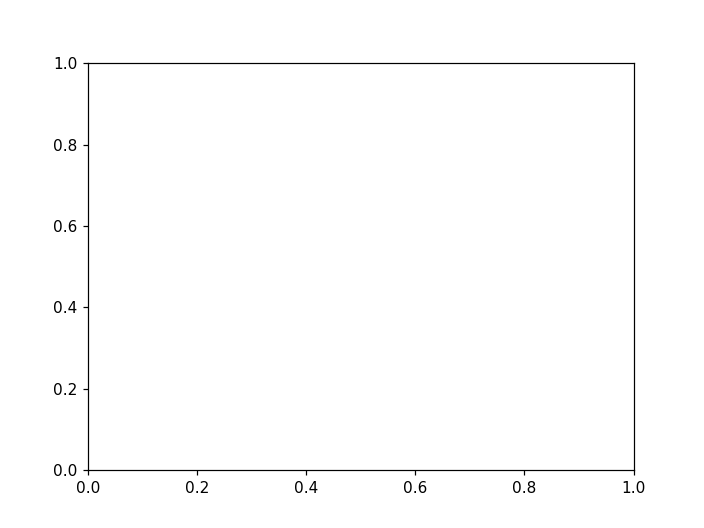

<IPython.core.display.Javascript object>


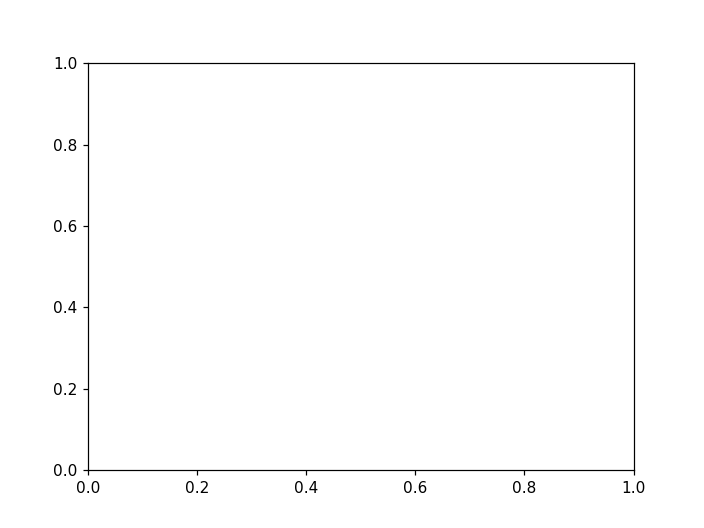

In [6]:
##### >>>>> RUN THIS CELL #8 <<<<< #####

# Plot # its really handy to run this cell before 1st run of any cells that align sample(s)
# fig_height = plt.figure(1)
# ax_height = plt.axes()
# fig_pitch = plt.figure(2)
# ax_pitch = plt.axes()


def create_figs():
    fig_height, ax_height = plt.subplots(1,1)
    fig_pitch, ax_pitch = plt.subplots(1,1)
    return fig_height, ax_height, fig_pitch, ax_pitch

fig_height, ax_height, fig_pitch, ax_pitch = create_figs()


In [ ]:
# you can skip this is u want, then it will use settings already set above 
#alignment scan settings - you can change these to REFINE your alignments

# height and Omega scan parameters
align_height_coarse_range = [-0.5,0.5]
align_height_coarse_points = 31
align_height_fine_range = [-0.05,0.05]
align_height_fine_points = 41
align_coarse_omega_range = [-1.5,1.5]
align_coarse_omega_points = 51
align_fine_omega_range = [-0.5,0.5]
align_fine_omega_points = 31

In [13]:
gsaxs_slit_centre_y.get()

10.166554106755465

In [19]:
 gsaxs_slit_centre_y.set(10.166554106755465)

Status(obj=RedisSignal(name='gsaxs_slit_centre_y'), done=False, success=False)

In [ ]:
slit_scan_centre(-0.5, 0.5, 101)

In [20]:
gsaxs_slit_centre_y.get()

10.166554106755465

In [ ]:
setup_for_acquisition()

In [21]:
## Substrate alignment - run me first 
def substrate_alignment_0(def_omega = 0.1):
    ###################################################
    # STEP 1
    # this cell will align a sample, then leave it at non zero angle and at
    # beam height ready to shoot
#    set_motors_to_full_speed()

    # Press CTRL-Enter to align
    mono_shutter_open.put(1)
    #sleep(5)

    # Move to the first sample position and align the omega (tilt) and Y
#    saved_blade_height = mc8.h.position
#    mc8.h.relmv(3, wait = True) #relative movement

    align_and_scan_that_thang('sample_4_gisaxs', scan=False)

#    mc8.h.move(saved_blade_height, wait = True) #Move the blade back 

    print('Results')
    #pre_alignment position guff
    print('translation =', gsaxs.x.position)
    print('height =', gsaxs.y.position)
    print('pitch_dial', gsaxs.omega.dial.get())

    print('I am moving the sample to a non-zero angle to allow u to shoot manually and check scattering data....')
    gsaxs.omega.move(def_omega, wait=True)

    print("Done everything for you, Master")
    #########################
    #########################

Starting Alignment
Setting up for Alignment
Finished Setting up for Alignment




Transient Scan ID: 4     Time: 2025-03-20 16:05:58
Persistent Unique Scan ID: 'f68c3c24-db5b-4e72-a7f2-76e6bd35715b'
New stream: 'primary'
+-----------+------------+------------+-----------------------------+
|   seq_num |       time |     counts | SAXSDetector_full_file_name |
+-----------+------------+------------+-----------------------------+
|         1 | 16:05:58.3 |     298708 |                         /da |
+-----------+------------+------------+-----------------------------+
generator count ['f68c3c24'] (scan num: 4)



beam_counts: 298708.0
Coarse Height Scan


Transient Scan ID: 5     Time: 2025-03-20 16:06:00
Persistent Unique Scan ID: 'dc955655-c1b3-467f-8391-030e37ff035e'
New stream: 'primary'


<IPython.core.display.Javascript object>


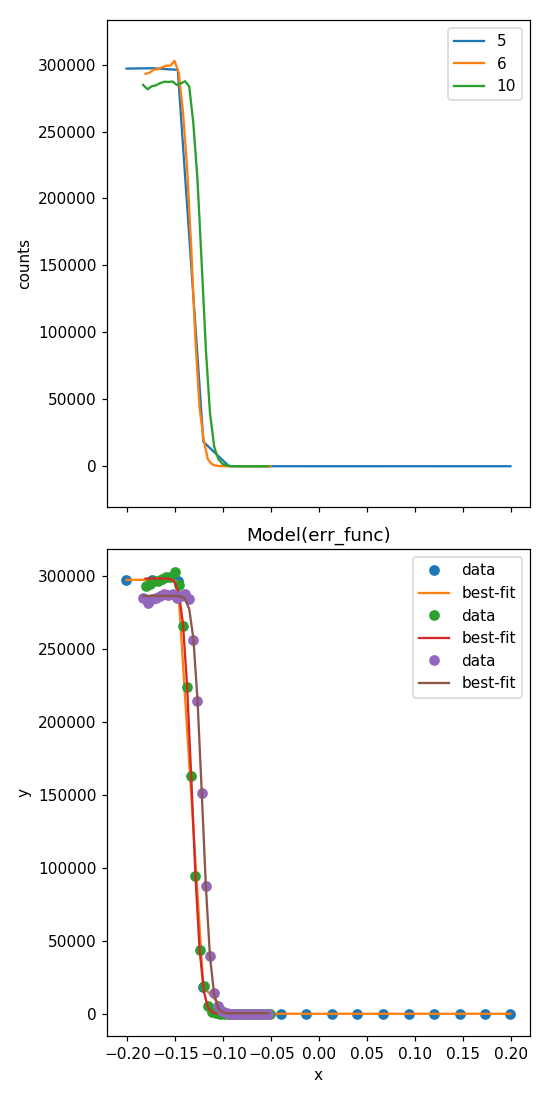

+-----------+------------+-------------+------------+-----------------------------+
|   seq_num |       time | GSAXS_Rig_y |     counts | SAXSDetector_full_file_name |
+-----------+------------+-------------+------------+-----------------------------+
|         1 | 16:06:02.8 |     -0.2009 |     296965 |                         /da |


/opt/conda/lib/python3.7/site-packages/bluesky/callbacks/best_effort.py:274: UserWarning: Omitting SAXSDetector_full_file_name from plot because dtype is string
  "".format(y_key, dtype))


|         2 | 16:06:04.7 |     -0.1742 |     297256 |                         /da |
|         3 | 16:06:06.6 |     -0.1475 |     296050 |                         /da |
|         4 | 16:06:08.5 |     -0.1208 |      18254 |                         /da |
|         5 | 16:06:10.5 |     -0.0941 |         10 |                         /da |
|         6 | 16:06:12.4 |     -0.0676 |          2 |                         /da |
|         7 | 16:06:14.3 |     -0.0405 |          2 |                         /da |
|         8 | 16:06:16.2 |     -0.0143 |          1 |                         /da |
|         9 | 16:06:18.2 |      0.0128 |          1 |                         /da |
|        10 | 16:06:20.1 |      0.0395 |          1 |                         /da |
|        11 | 16:06:22.0 |      0.0662 |          0 |                         /da |
|        12 | 16:06:23.9 |      0.0928 |          2 |                         /da |
|        13 | 16:06:25.8 |      0.1191 |          0 |                       



Transient Scan ID: 7     Time: 2025-03-20 16:07:15
Persistent Unique Scan ID: '28d39a40-b1db-45a0-83f2-39f701b5f42f'
New stream: 'primary'
+-----------+------------+------------+-----------------------------+
|   seq_num |       time |     counts | SAXSDetector_full_file_name |
+-----------+------------+------------+-----------------------------+
|         1 | 16:07:15.8 |     148459 |                         /da |
Counts: 148459.0, Target: 149354.0
+-----------+------------+------------+-----------------------------+
generator count ['28d39a40'] (scan num: 7)



Coarse Omega Scan


Transient Scan ID: 8     Time: 2025-03-20 16:07:16
Persistent Unique Scan ID: '4008a82a-db76-4313-a87b-36981f88f51f'
New stream: 'primary'


<IPython.core.display.Javascript object>


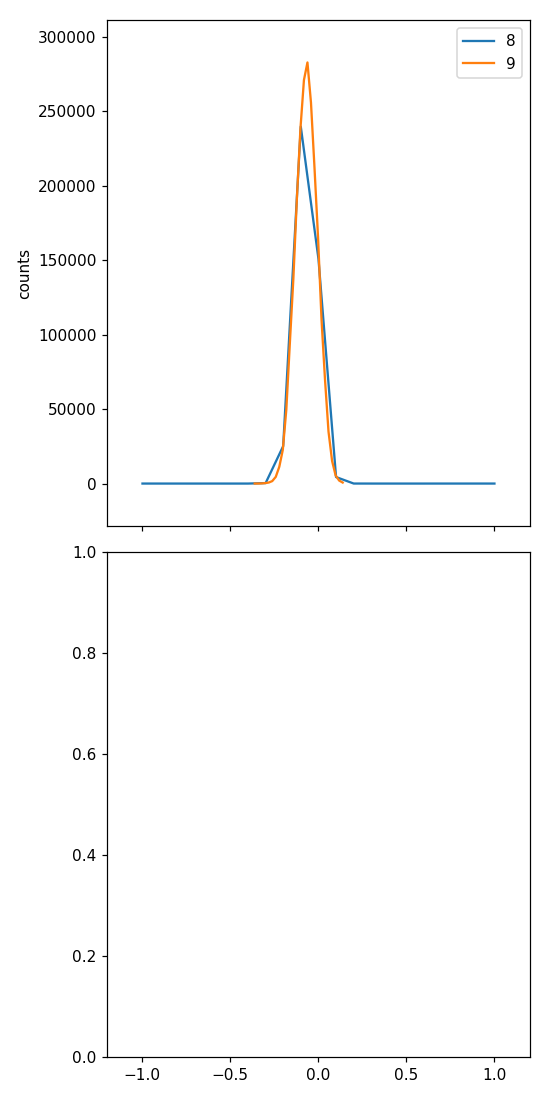

+-----------+------------+-----------------+------------+-----------------------------+
|   seq_num |       time | GSAXS_Rig_omega |     counts | SAXSDetector_full_file_name |
+-----------+------------+-----------------+------------+-----------------------------+
|         1 | 16:07:19.1 |         -0.9988 |         13 |                         /da |
|         2 | 16:07:20.6 |         -0.8992 |          9 |                         /da |
|         3 | 16:07:22.1 |         -0.7992 |          9 |                         /da |
|         4 | 16:07:23.6 |         -0.6996 |          4 |                         /da |
|         5 | 16:07:25.1 |         -0.5993 |         11 |                         /da |
|         6 | 16:07:26.5 |         -0.4996 |          3 |                         /da |
|         7 | 16:07:28.0 |         -0.3992 |          7 |                         /da |
|         8 | 16:07:29.5 |         -0.2993 |        331 |                         /da |
|         9 | 16:07:30.9 |      

Fine Height Scan


Transient Scan ID: 10     Time: 2025-03-20 16:08:48
Persistent Unique Scan ID: '83bc1b17-c413-4138-8d20-cd33f36ebb41'
New stream: 'primary'
+-----------+------------+-------------+------------+-----------------------------+
|   seq_num |       time | GSAXS_Rig_y |     counts | SAXSDetector_full_file_name |
+-----------+------------+-------------+------------+-----------------------------+
|         1 | 16:08:50.0 |     -0.1836 |     284811 |                         /da |
|         2 | 16:08:50.8 |     -0.1790 |     281531 |                         /da |
|         3 | 16:08:51.5 |     -0.1746 |     283821 |                         /da |
|         4 | 16:08:52.3 |     -0.1703 |     284460 |                         /da |
|         5 | 16:08:53.0 |     -0.1660 |     286097 |                         /da |
|         6 | 16:08:53.8 |     -0.1616 |     287187 |                         /da |
|         7 | 16:08:54.5 |     -0.1572 |     286958 |                         /da |
|

Finished Setting up for Acquisition
Results
translation = 20.0
height = -0.12223447564473844
pitch_dial -0.7575
I am moving the sample to a non-zero angle to allow u to shoot manually and check scattering data....
Done everything for you, Master


In [26]:
substrate_alignment_0()

In [ ]:
## Substrate alignment - run me first 
def substrate_alignment(def_omega = 0.1):
    ###################################################
    # STEP 1
    # this cell will align a sample, then leave it at non zero angle and at
    # beam height ready to shoot
    set_motors_to_full_speed()

    # Press CTRL-Enter to align
    mono_shutter_open.put(1)
    #sleep(5)

    # Move to the first sample position and align the omega (tilt) and Y
    saved_blade_height = mc8.h.position
    mc8.h.relmv(3, wait = True) #relative movement

    align_and_scan_that_thang('sample_4_gisaxs', scan=False)

    mc8.h.move(saved_blade_height, wait = True) #Move the blade back 

    print('Results')
    #pre_alignment position guff
    print('translation =', gsaxs.x.position)
    print('height =', gsaxs.y.position)
    print('pitch_dial', gsaxs.omega.dial.get())

    print('I am moving the sample to a non-zero angle to allow u to shoot manually and check scattering data....')
    gsaxs.omega.move(def_omega, wait=True)

    print("Done everything for you, Master")
    #########################
    #########################

In [ ]:
# Run a general alignment.
fig_height, ax_height, fig_pitch, ax_pitch = create_figs()
substrate_alignment()

In [ ]:
#### 00 - ALIGN YOUR SAMPLE, IF 1 position just do this one. Otherwise, if moving sample, then you need to do both endpoints (second move is below).


# FIRST MOVE TO THE INIT POSITION OF THE SAMPLE 
# (Where the blade starts above the sample corner, next to the needle), RUN THIS CODE

# Run the alignment:
fig_height, ax_height, fig_pitch, ax_pitch = create_figs()
substrate_alignment()

#pre_alignment position guff
print('translation =', gsaxs.x.position)
print('height =', gsaxs.y.position)
print('pitch_dial', gsaxs.omega.dial.get())

# Store the sample Y & X
gsaxs_sample_x_init = gsaxs.x.position
gsaxs_sample_y_init = gsaxs.y.position


In [ ]:
# SECOND MOVE TO THE FINAL POSITION OF THE SAMPLE 
# THIS IS THE END OF THE SAMPLE

# Run the alignment:
fig_height, ax_height, fig_pitch, ax_pitch = create_figs()
substrate_alignment()

#pre_alignment position guff
print('translation =', gsaxs.x.position)
print('height =', gsaxs.y.position)
print('pitch_dial', gsaxs.omega.dial.get())


# Store the sample X & Y
gsaxs_sample_y_fin = gsaxs.y.position
gsaxs_sample_x_fin = gsaxs.x.position


In [ ]:
# CALCUATE IF WE NEED TO CORRECT AS WE MOVE
tolerance = 0.005 #3 um height deviation
sample_y_correction_necessary: bool = abs(gsaxs_sample_y_init - gsaxs_sample_y_fin) > tolerance
if sample_y_correction_necessary:
    print(f"A height correction will be as devation is {gsaxs_sample_y_init - gsaxs_sample_y_fin:0.3f}")
else:
    print(f"No height correction necessary (deviation: {gsaxs_sample_y_init - gsaxs_sample_y_fin:0.3f})")

# Calculate the correction value needed:
#(mm to translate sample height when moving x in positive direction)
x_delta = (gsaxs_sample_x_fin - gsaxs_sample_x_init)
if x_delta < 0: 
    raise ValueError("The code isn't setup for this direction of translation.")
    
sample_y_correction = (gsaxs_sample_y_fin - gsaxs_sample_y_init)
sample_y_slope = sample_y_correction / x_delta
print(f"The sample height correction is {sample_y_correction} mm")


In [ ]:
substrate_alignment()

In [ ]:
set_motors_to_full_speed()

In [ ]:
# ABORT SCANS ONCE STARTED press stop in jupyter (browser) x2 then run this
# hit shift-enter in this cell to abort an alignment or acquisition
try:
    RE.abort()
except Exception:
    pass

sa.abort()

In [ ]:
#### 01 SETUP MEAUREMENT CELL 

# motor setting inputs for McNeill in-situ

# what are the motors ???
# blade translation is mc8.f
# blade height is mc8.h
# sample x translation is gsaxs.x
# sample y translation is gsaxs.y
# syringe_pump motor = mc7.syringe_pump2

base_name = "R03_03"
# `insitu_filename` created in each subscript

insitu_exposure_time = 0.1 #0.04
incident_angle = 0.04

# optional initial move of blade
use_first_blade_translation = False  #do it?
blade_first_translation_distance = 1 #mm
blade_first_velocity = 10 #mm/s?

# main movement of blade
blade_translation_distance = 20 #(mm) just use positive number as direction will be negative anyway
blade_velocity = 5 #mm/s

#RT: Should we include the stage temperature here? It will not actually set it, but it could be written into the file later. 

# Time calculation for exposures
total_time = 35
number_of_insitu_exposures = int(total_time / insitu_exposure_time)

# Move sample
sample_movement: bool = True # Do we move the sample, or just measure the same spot.
sample_x_distance = 3.5 # mm use positive number only #RT: Does this move the stage (inlcuding the blade) or just the substrate
# sample_x_velocity = 0.1 # mm/s, do not set above 2 mm/s 
sample_x_velocity = sample_x_distance/total_time # mm/s

# sample_height_correction = sample_y_correction #(mm to translate sample height when moving x in positive direction)
sample_height_correction = (sample_x_velocity * total_time) * sample_y_slope

use_sample_height_correction: bool = False # Can manually turn off the blade correction instead of setting to "sample_y_correction_necessary" variable.
# use_sample_height_correction = sample_y_correction_necessary # Can manually turn off the blade correction instead of setting to "sample_y_correction_necessary" variable.


injection_volume = 10 #(uL)
injection_flowrate = 5 #(uL/s) 

syringe_conversion_factor = 1000 / 60      #(uL/mm)
injection_translation  = injection_volume / syringe_conversion_factor #(note, ignores dead volume....., u might need to add dead volume ...)
injection_velocity = injection_flowrate / syringe_conversion_factor


# set motor parameters
mc8.f.velocity.put(abs(blade_first_velocity))
mc7.syringe_pump2.velocity.put(abs(injection_velocity))
gsaxs.x.velocity.put(abs(sample_x_velocity))
# note = uncoordinated height velocity in x_motor movement time moving y distance (in same time):
sample_translation_time = abs(sample_x_distance / sample_x_velocity)
if sample_height_correction != 0:
    sample_height_velocity = abs(sample_height_correction / sample_translation_time )
else :
    sample_height_velocity = 1
gsaxs.y.velocity.put(sample_height_velocity)
    
# Can manuall change this instead of just using the sample translation
# number_of_insitu_exposures = int(sample_translation_time / insitu_exposure_time)


if number_of_insitu_exposures > 5000:
    raise ValueError("THIS MIGHT BE TOO MANY???")

print('injection_translation', injection_translation, 'mm')
print('injection_velocity', injection_velocity, 'mm/s')
print('sample_translation_time', sample_translation_time, 's')
print('sample_height_velocity', sample_height_velocity, 'mm/s')
print('number_of_insitu_exposures', number_of_insitu_exposures)




In [ ]:
#### 02 DISPENSE

# McNeill in-situ semi fly scanning
#deposition of the fluid


gsaxs.omega.move(incident_angle, wait=True)

per_shot = sps.per_step_with_shutter_video_count
inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
plan = partial(gappy_plan,
               inner_plan,
               filename=Path(insitu_filename),
               exp_time=insitu_exposure_time,
               num_images_per_trigger=number_of_insitu_exposures,
               use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
               open_shutter=False)              


# move stuff to starting positions

# dispense fluid, wait until finished
mc7.syringe_pump2.relmv(-1 * injection_translation)

In [ ]:
# # initial move blade, and wait for it to move. will move negative
# if use_first_blade_translation == True:
#     mc8.f.velocity.put(blade_first_velocity)
#     mc8.f.relmv(-1 * blade_first_translation_distance)

In [ ]:
#### 03 Move and Measure

# McNeill in-situ semi fly scanning
insitu_filename = f'{base_name}_IN_SITU'

per_shot = sps.per_step_with_shutter_video_count
inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
plan = partial(gappy_plan,
                inner_plan,
                filename=Path(insitu_filename),
                exp_time=insitu_exposure_time,
                num_images_per_trigger=number_of_insitu_exposures,
                use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
                open_shutter=False)              
gsaxs.omega.move(incident_angle, wait=True)


# # move stuff to starting positions

# dispense fluid, wait until finished
# mc7.syringe_pump2.relmv(-1 * injection_translation, wait = True)

# # sleep_after injecting sample  a bit
# sleep(10)

# # move blade, either wait a bit or not. will move negative

# # do initial move of blade
# if use_first_blade_translation == True:
#     mc8.f.velocity.put(blade_first_velocity)
#     mc8.f.relmv(-1 * blade_first_translation_distance, wait = True)

# do main move of blade. Think about waiting for it, or not if speed of blade and sample make sense.....
start_time = time()

print('Now moving blade horizontally, and not waiting for it to finish')
mc8.f.velocity.put(blade_velocity)
current_blade_x_position = mc8.f.position
mc8.f.move(current_blade_x_position - blade_translation_distance, wait = False) # minus in this scpecific case to make blade move inboard
#sleep(1)


# open shutter....(maybe)
print('Now forcing shutter open', time() - start_time)

manual_shutter_open.put(1)

# start sample moving but do not wait
if sample_movement:
    print('Now moving sample horizontally, and possibly vertically to correct roll stuff, and not waiting for it to finish',  time() - start_time)
    current_gsaxs_x_position = gsaxs.x.position
    current_gsaxs_y_position = gsaxs.y.position

    gsaxs.x.move(current_gsaxs_x_position + sample_x_distance, wait = False) 
    if use_sample_height_correction == True: #is true
        gsaxs.y.move(current_gsaxs_y_position + sample_height_correction, wait = False)

# take continuous data
print('Now shooting SAXS data',  time() - start_time)
sa.queue({"type": "plan", "data": plan}, wait=True)


print("Done")
print('total time =',  time() - start_time)
print("Saving parameters to file...")

path = f"mcneill_{insitu_filename}_parameters.txt"
parameters = {
    "incident_angle" : (incident_angle, 'deg'),
    'injection_translation': (injection_translation, 'mm'),
    'injection_volume' : (injection_volume, 'ul'),
    'injection_velocity_motor': (injection_velocity, 'mm/s'),
    'injection_flowrate': (injection_flowrate, 'mm/s'),
    'blade_translation_distance_after_dispense' : (blade_first_translation_distance, 'mm'),
    'blade_first_velocity' : (blade_first_velocity, "mm/s"),
    'blade_translation_distance' : (blade_translation_distance, 'mm'),
    'blade_velocity' : (blade_velocity, 'mm/s'),
    'sample_translation_time': (sample_translation_time, 's'),
    'sample_height_velocity': (sample_height_velocity, 'mm/s'),
    'number_of_insitu_exposures': (number_of_insitu_exposures,),
    "insitu_exposure_time" : (insitu_exposure_time, 's'),
}

with open(path, "w") as f:
    for key, val in parameters.items():
        f.write(str(key) + "\t")
        if isinstance(val, (list, tuple)):
            f.write("\t".join([str(v) for v in val]) + "\n")
        else:
            f.write(val)
                    
print("Done")

# Reset the motors to full speed
set_motors_to_full_speed()


In [ ]:
#### 04 Ex-situ angle of incidence scan

# PERFORM ANGLE OF INCIDENCE MEASUREMENTS ON A SINGLE POINT AFTERWARDS! :)
# HAVE YOU CHANGED THE `base_name`??
insitu_filename = f'{base_name}_EX_SITU'
exp_time = 1
def acquire_shot(filename, exp_time):
    saxs_detector.auto_increment.put(1)
    #sa.acquire(filename=filename, exp_times=[exposure_time], wait=True)
    per_shot = gps.per_step_gapless_video_count
    inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
    plan = partial(
        gapless_plan,
        inner_plan,
        filename=Path(filename),
        exp_time=exp_time,
        use_feedback=True,
        open_shutter=True)
    sa.queue({"type": "plan", "data": plan}, wait=True)

angles = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2]
    
x_delta = 0.1 #mm
# 11 angles * 0.05 

for x_index, omega in enumerate(angles):
    aoi_filename = f"{insitu_filename}_AOI_scan_{omega:0.2f}".replace(".", "p")
    #in_vac.x.move(x, wait=True)
    gsaxs.omega.move(omega, wait=True)
#     fine_position = align_fibre(fine_start_offset, fine_stop_offset, fine_num_points, save=False, filename=filename)

    try:
        print(f'acquiring {omega:0.2f} aoi')
        acquire_shot(aoi_filename, exp_time)
    except TimeoutError as e:
        print(f'Timeout Error on aoi {omega}.')
        print(e)
        pass    
    
    current_gsaxs_x_position = gsaxs.x.position
    current_gsaxs_y_position = gsaxs.y.position
    gsaxs.x.move(current_gsaxs_x_position + x_delta, wait=True)
    if use_sample_height_correction:
        gsaxs.y.move(current_gsaxs_y_position + (x_delta * sample_y_slope), wait=True)
    
# Reset the motors to full speed
set_motors_to_full_speed()

print("done")

In [ ]:
# Reset the motors to full speed
set_motors_to_full_speed()

In [ ]:
###################################################################################################################
###################################################################################################################
#########################################END OF OUR SYSTEMS YIHAAAAAAAA############################################
###################################################################################################################
###################################################################################################################
###################################################################################################################


In [ ]:
set_motors_to_full_speed()

Setting up for Alignment
Finished Setting up for Alignment


Transient Scan ID: 3     Time: 2025-03-20 15:39:25
Persistent Unique Scan ID: 'a2b58523-45c2-4bd3-9c66-2b6a863ed74d'
New stream: 'primary'


<IPython.core.display.Javascript object>


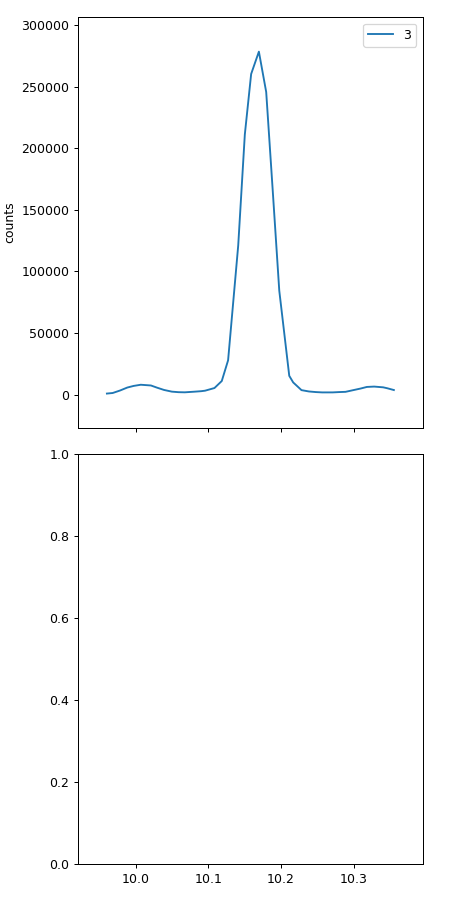

+-----------+------------+-------------------+------------+-----------------------------+
|   seq_num |       time | beamstop_stages_y |     counts | SAXSDetector_full_file_name |
+-----------+------------+-------------------+------------+-----------------------------+
|         1 | 15:39:26.3 |         9.9599675 |        845 |                         /da |
|         2 | 15:39:29.2 |         9.9679128 |       1294 |                         /da |
|         3 | 15:39:30.3 |         9.9779898 |       3297 |                         /da |
|         4 | 15:39:31.3 |         9.9880668 |       5733 |                         /da |
|         5 | 15:39:35.4 |         9.9967872 |       7045 |                         /da |
|         6 | 15:39:39.6 |        10.0066704 |       8003 |                         /da |
|         7 | 15:39:40.6 |        10.0206231 |       7412 |                         /da |
|         8 | 15:39:41.8 |        10.0291498 |       5619 |                         /da |
|         

Finished Setting up for Acquisition
10.166554106755465


In [11]:
#### Run this cell (shift-enter) to realign detector slit. ####
#safe_bs_pos_x, safe_bs_pos_y = [align_bs_x_pos , 0]

#set_motors_to_full_speed()
#slit_scan_centre(-0.5, 0.5, 81)
slit_scan_centre(-0.2, 0.2, 41)

In [ ]:
# run this cell to perform manual alignment (then cell afterward once done)
setup_for_alignment()
saxs_det_trigger_mode.put(4)
sleep(0.2)
saxs_det_acquire.put(1)
manual_shutter_open.put(1)
gsaxs.omega.move(0.0, wait=True)
print("Go align sample, and set omega zero")

In [ ]:
# run this cell after a manual alignment
manual_shutter_close.put(1)

saxs_det_acquire.put(0)
sleep(0.2)
saxs_det_trigger_mode.put(0)

setup_for_acquisition()
gsaxs.omega.move(0.1, wait=True)


In [ ]:
start_angle1 = 0.01
end_angle1 = 0.04
number_of_angles1 = 7
acquire_angles1 = np.linspace(start_angle1, end_angle1, number_of_angles1).round(3)
acquire_angles1

In [ ]:
setup_for_alignment()

In [ ]:
setup_for_acquisition()

In [ ]:
# actually change to GISAXS
print('Moving the detector to GISAXS position. I will be back soon. \n')
saxs_det.z.move(5268.0, wait = False)
beamstop.rotn.move(270.0, wait = False)
align_bs_x_pos, align_bs_y_pos = [-25.0, -4.0370779510822885]
setup_for_alignment()
saxs_det.z.move(5268.0, wait = True)
beamstop.rotn.move(270.0, wait = True)
beamstop.x.move(-25.0, wait = False)
align_transmission = 0.0001
gsaxs_slit_centre_y.put(-4.036964569190502)
print(gsaxs_slit_centre_y.get())
print('So now I am fine-aligning the beamstop slit. \n')
acquire_bs_pos = [align_bs_x_pos, -12]

slit_scan_centre(-0.4, 0.4, 81)
acquire_bs_pos = [align_bs_x_pos, -12]
setup_for_acquisition()
print('Hopefully things are ready for GISAXS.')

In [ ]:
# actually change to GIWAXS
print('Moving the detector to GISAXS position. I will be back soon. \n')
saxs_det.z.move(550.0, wait = False)
beamstop.rotn.move(90, wait = False)
align_bs_x_pos, align_bs_y_pos = [-25.2, -3.6171657056954927]
setup_for_alignment()
saxs_det.z.move(550.0, wait = True)
beamstop.rotn.move(90, wait = True)
beamstop.x.move(-25.2, wait = True)
gsaxs_slit_centre_y.put(-3.6171657056954927)
align_transmission = 0.00001
print(gsaxs_slit_centre_y.get())
print('So now I am fine-aligning the beamstop slit. \n')

#slit_scan_centre(-0.4, 0.4, 41)
acquire_bs_pos = [align_bs_x_pos, -8]
setup_for_acquisition()
print('Hopefully things are ready for GIWAXS.')

In [ ]:
mc7.syringe_pump2.position

In [ ]:
mc8.f.max_velocity.get()

In [ ]:
gsaxs.x.velocity.put(gsaxs.x.max_velocity.get())

In [ ]:
# motor setting inputs.

# what are the motors ???
# blade translation is mc8.f
# blade height is mc8.h
# sample x translation is gsaxs.x
# sample y translation is gsaxs.y
# syringe_pump motor = mc7.syringe_pump2

def set_motors_to_full_speed():
    mc8.f.velocity.put(mc8.f.max_velocity.get())
    mc8.h.velocity.put(mc8.h.max_velocity.get())
    gsaxs.x.velocity.put(gsaxs.x.max_velocity.get())
    gsaxs.y.velocity.put(gsaxs.y.max_velocity.get())

    mc7.syringe_pump2.velocity.put(mc7.syringe_pump2.max_velocity.get())

In [ ]:
set_motors_to_full_speed()

In [ ]:
time()

In [ ]:
sample_height_velocity

In [ ]:
sleep(1)
print('test')

In [ ]:
exp_shutter.close_shutter()

In [ ]:
manual_shutter_open.put(1)

In [ ]:
manual_shutter_close.put(1)

In [ ]:
##
## Omega scan 
## this cell simply shoots sample. assumes it has been aligned.

saxs_det.x.move(acquire_det_x, wait = True)
saxs_det.y.move(acquire_det_y, wait = True)


## narrow scan
start_angle = 0.03
end_angle = 0.1
number_of_angles = 8
#acquire_angles = np.linspace(start_angle, end_angle, number_of_angles).round(3)

x_step_size = 0.08

#acquire_angles = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                #0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20,
                #0.22, 0.24, 0.26, 0.28, 0.3, 0.35, 0.4,
                #0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3  ]
 
            
acquire_angles = [0.05, 0.1, 0.15, 0.2]
beamstop_positions = [-10.5, -10.5, -10.5, -10.5]
            
            
print(acquire_angles)

my_filename = 'sample_4_gisaxs'    ### Where to change file name
################################
startoffset= 0 
#beamstop_positions = [-5]*len(acquire_angles)
exposure_time = 1                                                                   ## Where to change exposure   
start_position = gsaxs.x.position
print('Starting position = ', start_position)
end_position = start_position + x_step_size*len(acquire_angles)+startoffset
print('end_position = ', end_position)
path = saxs_detector.file_path.get()
setup_for_acquisition()

# this next line would just shoot
scan_that_thang(my_filename)
gsaxs.x.move(start_position, wait = True)


print('acquisition is done')


In [ ]:
 #saving code here for later 
#start_angle = 0.01           ## start angle
#end_angle = 0.02            ## end angle
#number_of_angles = 3        ## Number of angles between start and end
#x_step_size = 0.05
#acquire_angles = np.linspace(start_angle, end_angle, number_of_angles).round(3)

'''
start_angle1 = 0.01
end_angle1 = 0.1
number_of_angles1 = 19
acquire_angles1 = np.linspace(start_angle1, end_angle1, number_of_angles1).round(3)
start_angle2 = 0.1
end_angle2 = 0.2
number_of_angles2 = 11
acquire_angles2 = np.linspace(start_angle2, end_angle2, number_of_angles2).round(3)

acquire_angles = np.concatenate((acquire_angles1, acquire_angles2))

'''